In [4]:
import sys
sys.path.append('../notebooks')
import utils
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'confi

In [5]:
os.environ['KERAS_BACKEND'] = 'theano'
# TODO: Use float16 ?
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge, RepeatVector, Permute, Reshape
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, MaxoutDense
from keras.layers import LeakyReLU
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.utils.layer_utils import print_summary
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 4007)


In [6]:
import theano
print theano.config.device

gpu0


In [7]:
from keras.layers import Layer, InputSpec
import keras.initializations
import keras.backend as K

class Maxout2D(Layer):
    def __init__(self, output_dim, cardinality, init='glorot_uniform', **kwargs):
        super(Maxout2D, self).__init__(**kwargs)
        # the k of the maxout paper
        self.cardinality = cardinality
        # the m of the maxout paper
        self.output_dim = output_dim
        self.init = keras.initializations.get(init)
    
    def build(self, input_shape):
        self.input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_shape[1], input_shape[2], input_shape[3]))]
        self.W = self.init((self.input_dim, self.output_dim, self.cardinality),
                           name='{}_W'.format(self.name))
        self.b = K.zeros((self.output_dim, self.cardinality))
        self.trainable_weights = [self.W, self.b]
              
    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        # flatten the spatial dimensions
        flat_x = K.reshape(x, (-1, input_shape[1], input_shape[2] * input_shape[3]))
        output = K.dot(
            K.permute_dimensions(flat_x, (0, 2, 1)),
            K.permute_dimensions(self.W, (1, 0, 2))
        )
        output += K.reshape(self.b, (1, 1, self.output_dim, self.cardinality))
        output = K.max(output, axis=3)
        output = output.transpose(0, 2, 1)
        output = K.reshape(output, (-1, self.output_dim, input_shape[2], input_shape[3]))
        return output
    
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.output_dim, input_shape[2], input_shape[3])
    
    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'cardinality': self.cardinality
        }
        base_config = super(Maxout2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    # maxout in numpy
    X = np.random.rand(10, 2, 3, 4)
    X = X.reshape(10, 2, 3 * 4) # 10, 3, 30

    # cardinality
    k = 2
    # output dim
    m = 7
    d = X.shape[1]

    #W = np.random.rand(d, m, k)
    W = np.ones((d, m, k), dtype=np.float32)
    for i in range(m):
        W[:,i,:] = i

    #X[0].T.dot(W[:,0,:]).shape

    print X.transpose(0, 2, 1).shape
    print W.transpose(1, 0, 2).shape

    out = np.dot(X.transpose(0, 2, 1), W.transpose(1, 0, 2))
    #out = np.tensordot(X.transpose(0, 2, 1), W.transpose(0, 1, 2), axes=1)
    out = np.max(out, axis=3)
    out = out.transpose(0, 2, 1)
    out = out.reshape(10, out.shape[1], 3, 4)
    print out.shape
    print out[0]

    k_W = K.variable(W)
    k_X = K.variable(X)

    flat_x = K.reshape(k_X, (-1, 2, 3 * 4))

    output = K.dot(
        K.permute_dimensions(flat_x, (0, 2, 1)),
        K.permute_dimensions(k_W, (1, 0, 2))
    )
    output = K.max(output, axis=3)
    output = output.transpose(0, 2, 1)
    output = K.reshape(output, (-1, W.shape[1], 3, 4))

    _f = K.function([], [output])
    k_out = _f([])[0]
    print k_out.shape
    print k_out

In [13]:
def line_rect_intersect(w, b, xmin, xmax, ymin, ymax):
    """
    Compute intersection of a line (y=w*x + b) with both sides of an image
    """
    assert np.abs(w) > 1e-6
    
    # left intersection
    left_intercept = w * xmin + b
    if left_intercept < ymin:
        # intersection with y = ymin
        yleft = ymin
    elif left_intercept > ymax:
        # intersection with y = ymax
        yleft = ymax - 1
    else: # inside
        yleft = left_intercept
    xleft = (yleft - b) / w
        
    # right intersection
    right_intercept = w * xmax + b
    if right_intercept < ymin:
        yright = ymin
    elif right_intercept > ymax:
        yright = ymax - 1
    else:
        yright = right_intercept
    xright = (yright - b) / w
        
    return xleft, yleft, xright, yright

def plot_line(w, b, **kwargs):
    xmin, xmax = pl.xlim()
    ymin, ymax = pl.ylim()
    x1, y1, x2, y2 = line_rect_intersect(w, b, xmin, xmax, ymin, ymax)
    pl.plot([x1, x2], [y1, y2], **kwargs)
    pl.ylim((ymin, ymax))
    pl.xlim((xmin, xmax))

In [24]:
def train_model(fn, cardinality, verbose, nb_epoch=20):
    # -- the model (the spatial (2,2) shape is arbitrary and is just because the layer requires
    # a spatial dimension)
    input_img = x = Input(shape=(1, 2, 2))
    x = Maxout2D(1, cardinality)(x)
    model = Model(input=input_img, output=x)
    model.compile(optimizer='adam', loss='mse')
    print_summary(model.layers)
    
    # -- compute y = fn(x)
    def get_XY(x):
        X = np.tile(
            x.reshape(-1, 1, 1, 1),
            (1, 1, 2, 2)
        )
        y = fn(x)
        Y = np.tile(
            y.reshape(-1, 1, 1, 1),
            (1, 1, 2, 2)
        )
        return X, Y
    
    # For train, random x in [-1, 1]
    X_train, Y_train = get_XY(2 * np.random.rand(1000) - 1)
    # For test, nicely ordered x in [-1, 1] so we can plot
    X_test, Y_test = get_XY(x = np.linspace(-1, 1, 100))
    model.fit(X_train, Y_train, batch_size=16, nb_epoch=nb_epoch, verbose=verbose)
    
    Y_pred = model.predict(X_test)
    return model, X_test, Y_pred, Y_test

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_4 (InputLayer)               (None, 1, 2, 2)     0                                            
____________________________________________________________________________________________________
maxout2d_4 (Maxout2D)              (None, 1, 2, 2)     12          input_4[0][0]                    
Total params: 12
____________________________________________________________________________________________________


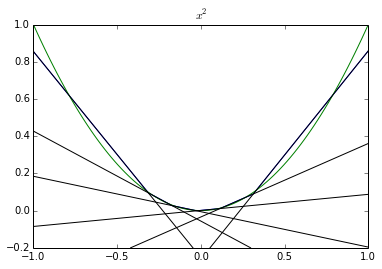

In [18]:
model, X_test, Y_pred, Y_test = train_model(lambda x : x**2, 6, verbose=0)

W, b = model.layers[1].get_weights()

pl.title('$x^2$')
pl.plot(X_test[:,0,0,0], Y_pred[:,0,0,0])
pl.plot(X_test[:,0,0,0], Y_test[:,0,0,0], c='g')

for i in range(W.shape[2]):
    plot_line(W[0, 0, i], b[0, i], c='k')

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_7 (InputLayer)               (None, 1, 2, 2)     0                                            
____________________________________________________________________________________________________
maxout2d_7 (Maxout2D)              (None, 1, 2, 2)     4           input_7[0][0]                    
Total params: 4
____________________________________________________________________________________________________


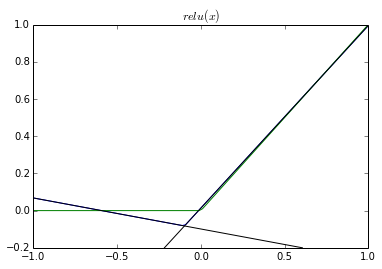

In [21]:
model, X_test, Y_pred, Y_test = train_model(lambda x : np.maximum(x, 0), 2, verbose=0)

W, b = model.layers[1].get_weights()

pl.title('$relu(x)$')
pl.plot(X_test[:,0,0,0], Y_pred[:,0,0,0])
pl.plot(X_test[:,0,0,0], Y_test[:,0,0,0], c='g')

for i in range(W.shape[2]):
    plot_line(W[0, 0, i], b[0, i], c='k')

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_12 (InputLayer)              (None, 1, 2, 2)     0                                            
____________________________________________________________________________________________________
maxout2d_12 (Maxout2D)             (None, 1, 2, 2)     4           input_12[0][0]                   
Total params: 4
____________________________________________________________________________________________________


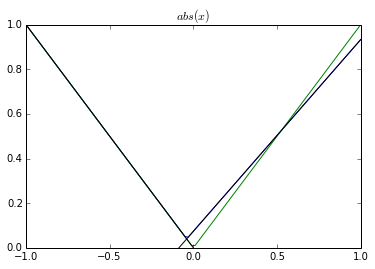

In [27]:
model, X_test, Y_pred, Y_test = train_model(lambda x : np.abs(x), 2, verbose=0, nb_epoch=60)

W, b = model.layers[1].get_weights()

pl.title('$abs(x)$')
pl.plot(X_test[:,0,0,0], Y_pred[:,0,0,0])
pl.plot(X_test[:,0,0,0], Y_test[:,0,0,0], c='g')

for i in range(W.shape[2]):
    plot_line(W[0, 0, i], b[0, i], c='k')

## 2D

<matplotlib.colorbar.Colorbar instance at 0x7f585c2a4b48>

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


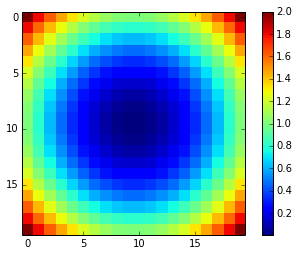

In [28]:
ij = np.dstack(np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 20)))
x = ij.reshape(-1, 2)
# a 2D convex function
z = np.sum(x**2, axis=1)
z = z.reshape(ij.shape[0], ij.shape[1])
pl.imshow(z, interpolation='nearest')
pl.colorbar()

In [29]:
W, b = model.layers[1].get_weights()
print W.shape

(1, 1, 2)


In [30]:
cardinality = 16
fn = lambda x : np.sum(x**2, axis=1)

input_img = x = Input(shape=(2, 2, 2))
x = Maxout2D(1, cardinality)(x)
model = Model(input=input_img, output=x)
model.compile(optimizer='adam', loss='mse')
print_summary(model.layers)

# -- compute y = fn(x)
def get_XY(x):
    X = np.tile(
        x.reshape(-1, 2, 1, 1),
        (1, 1, 2, 2)
    )
    y = fn(x)
    Y = np.tile(
        y.reshape(-1, 1, 1, 1),
        (1, 1, 2, 2)
    )
    return X, Y

# For train, random x in [-1, 1]
X_train, Y_train = get_XY(2 * np.random.rand(10000, 2) - 1)
# For test, nicely ordered x in [-1, 1] so we can plot
ij = np.dstack(np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 20)))
X_test, Y_test = get_XY(ij.reshape(-1, 2))
model.fit(X_train, Y_train, batch_size=64, nb_epoch=30, verbose=2)

Y_pred = model.predict(X_test)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_13 (InputLayer)              (None, 2, 2, 2)     0                                            
____________________________________________________________________________________________________
maxout2d_13 (Maxout2D)             (None, 1, 2, 2)     48          input_13[0][0]                   
Total params: 48
____________________________________________________________________________________________________
Epoch 1/30
0s - loss: 0.0649
Epoch 2/30
0s - loss: 0.0405
Epoch 3/30
0s - loss: 0.0340
Epoch 4/30
0s - loss: 0.0286
Epoch 5/30
0s - loss: 0.0240
Epoch 6/30
0s - loss: 0.0204
Epoch 7/30
0s - loss: 0.0174
Epoch 8/30
0s - loss: 0.0151
Epoch 9/30
0s - loss: 0.0134
Epoch 10/30
0s - loss: 0.0120
Epoch 11/30
0s - loss: 0.0109
Epoch 12/30
0s - loss: 0.0100
Epoch 13/30
0s - loss: 0.0

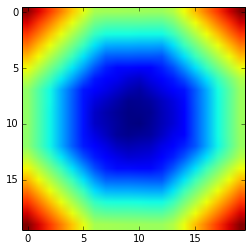

In [31]:
pl.imshow(Y_pred[:,0,0,0].reshape(20, 20))